In [1]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [63]:
price_df = pd.read_csv("gecko_price.csv", index_col=0)
mktcap_df = pd.read_csv("gecko_marketcap.csv", index_col=0)

price_df.index = pd.to_datetime(price_df.index)
mktcap_df.index = pd.to_datetime(mktcap_df.index)

In [64]:
daily_return = price_df.pct_change()
weekly_return = price_df.pct_change(7)

problematic_cols = []
for col in daily_return.columns:
    if daily_return[col].max() > 10000:
        problematic_cols.append(col)

daily_return = daily_return.drop(problematic_cols, axis=1)
weekly_return = weekly_return.drop(problematic_cols, axis=1)
mktcap_df = mktcap_df.drop(problematic_cols, axis=1)

In [65]:
screen_by_mktcap = mktcap_df.applymap(lambda x: 1 if x>1_000_000 else np.nan)

In [66]:
problematic_idxs = []

count_before = 0
tmp = screen_by_mktcap.count(axis=1)
for idx in tqdm(screen_by_mktcap.index):
    target_val = tmp.loc[idx]
    if count_before != 0:
        if (target_val - count_before) / count_before < -0.5:
            #print(idx)
            problematic_idxs.append(idx)
    count_before = target_val

100%|██████████| 3593/3593 [00:00<00:00, 70687.75it/s]


In [67]:
daily_return = daily_return.drop(problematic_idxs, axis=0)
weekly_return = weekly_return.drop(problematic_idxs, axis=0)
pf_mktcap_weighted = mktcap_df.drop(problematic_idxs, axis=0)
mktcap_df = mktcap_df.drop(problematic_idxs, axis=0)
screen_by_mktcap = screen_by_mktcap.drop(problematic_idxs, axis=0)

In [68]:
mktcap_df_screened = mktcap_df * screen_by_mktcap

In [69]:
mktcap_df_screened.count(axis=1)

2013-04-28      4
2013-04-29      3
2013-04-30      4
2013-05-01      4
2013-05-02      3
             ... 
2023-02-24    208
2023-02-25    209
2023-02-26    204
2023-02-27    202
2023-02-28    201
Length: 3587, dtype: int64

In [70]:
mktcap_weight = mktcap_df_screened.apply(lambda x: x/np.nansum(x), axis=1)
tmp = mktcap_df_screened.copy()
tmp[tmp.isna()==False] = 1
equal_weight = tmp.apply(lambda x: x/x.count(), axis=1)

In [71]:
equal_weight.count(axis=1)

2013-04-28      4
2013-04-29      3
2013-04-30      4
2013-05-01      4
2013-05-02      3
             ... 
2023-02-24    208
2023-02-25    209
2023-02-26    204
2023-02-27    202
2023-02-28    201
Length: 3587, dtype: int64

<AxesSubplot:>

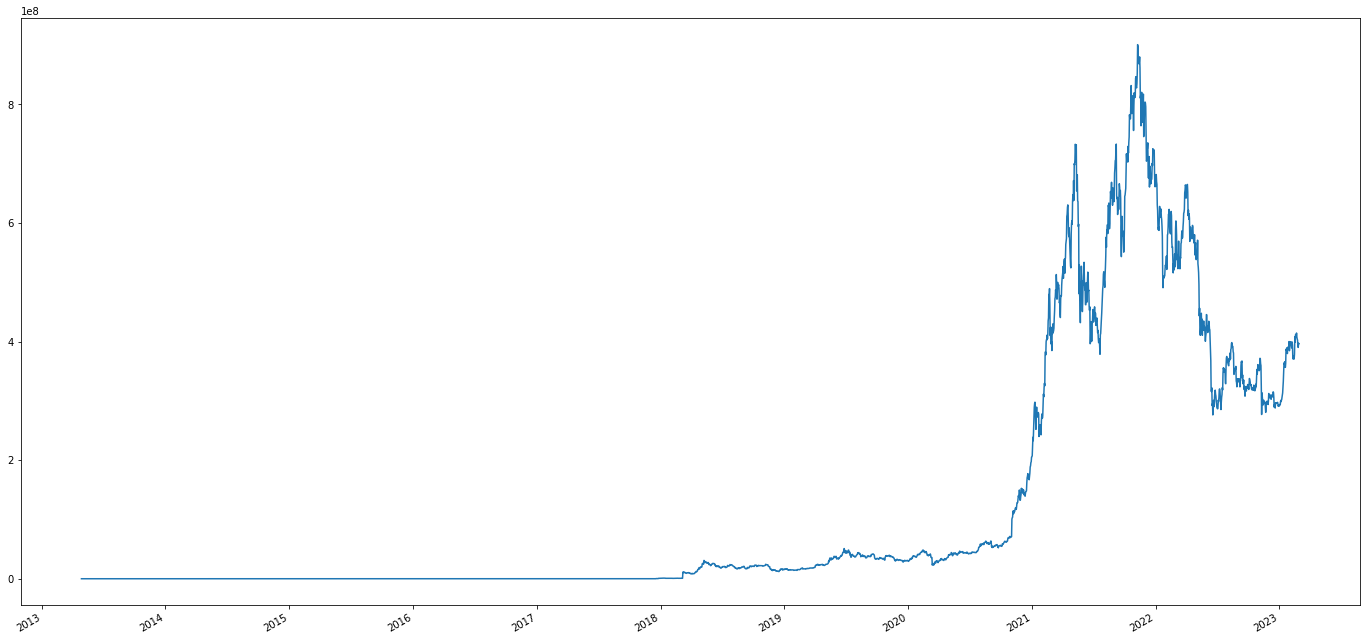

In [74]:
pf_return = (daily_return*mktcap_weight).sum(axis=1)

plt.figure(figsize=(24,12))
(pf_return+1).cumprod().loc[:].plot()

In [77]:
pf_self_weekly_return = (pf_return+1).cumprod().pct_change(7)

In [110]:
q1_pf_return = pf_self_weekly_return[pf_self_weekly_return >= pf_self_weekly_return.quantile(0.66)]

q2_pf_return = pf_self_weekly_return[pf_self_weekly_return < pf_self_weekly_return.quantile(0.66)]
q2_pf_return = q2_pf_return[q2_pf_return >= pf_self_weekly_return.quantile(0.33)]

q3_pf_return = pf_self_weekly_return[pf_self_weekly_return < pf_self_weekly_return.quantile(0.33)]

In [99]:
pf_self_weekly_return.quantile(0.66)

0.05416087496540608

<AxesSubplot:>

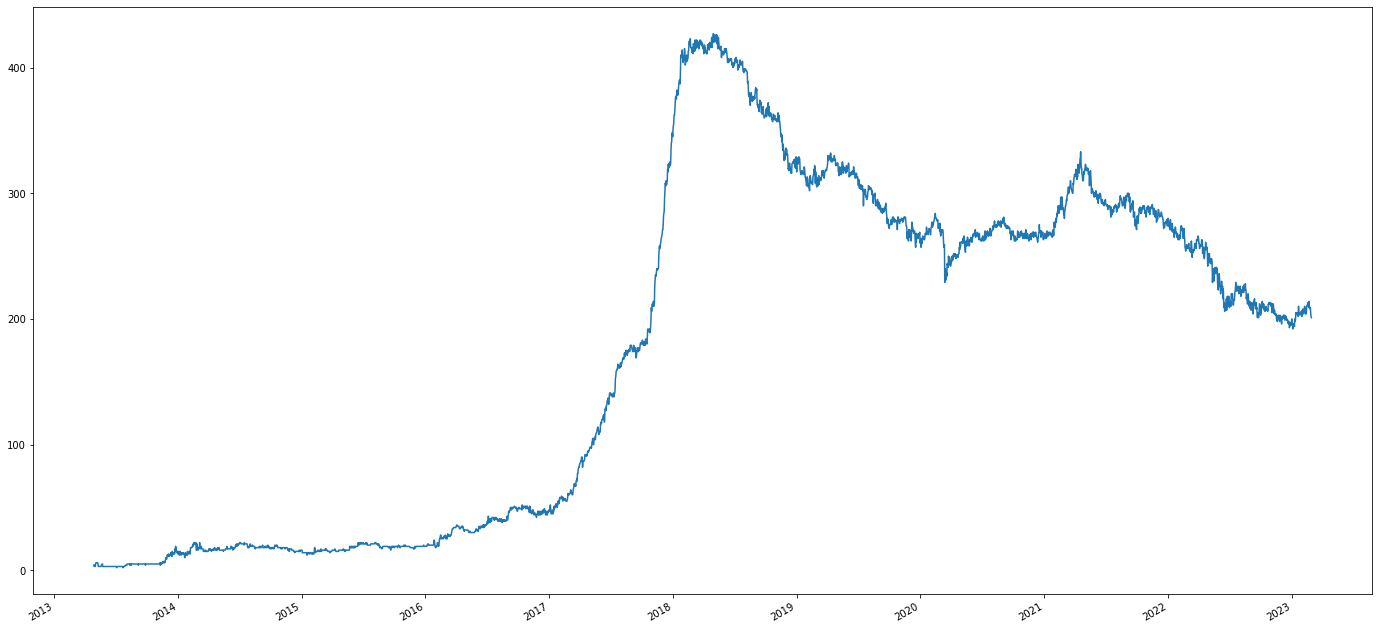

In [75]:
plt.figure(figsize=(24,12))
screen_by_mktcap.count(axis=1).plot()